## Overview

A complete blood cell (CBC) count is an important test often requested by medical professionals to evaluate health condition. The main three types of cells that constitute blood are red blood cells (RBCs), white blood cells (WBCs), and platelets.
The CBC dataset contains 360 blood smear images along with their annotation files splitting into Training and Testing sets. The training folder contains 300 images with annotations. The testing folder contains 60 images with annotations. Annotations provided in .xml files.
Link to download dataset:
https://github.com/MahmudulAlam/Complete-Blood-Cell-Count-Dataset 

## Import libraries

In [2]:
import os, sys, random
import xml.etree.ElementTree as ET
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [3]:
cwd = os.getcwd()
print(cwd)

/Users/klynete/Desktop/Springboard/Complete-Blood-Cell-Count/CBC


In [4]:
folders=['Training', 'Testing']
for f in folders:
    df = []
    cnt = 0
    file_annotations = glob(f'{cwd}/{f}/Annotations/*.xml')
    for file in file_annotations:
        row = []
        parsedXML = ET.parse(file)
        filename=parsedXML.getroot().find('filename').text
        for node in parsedXML.getroot().iter('object'):
            blood_cells = node.find('name').text
            xmin = int(node.find('bndbox/xmin').text)
            xmax = int(node.find('bndbox/xmax').text)
            ymin = int(node.find('bndbox/ymin').text)
            ymax = int(node.find('bndbox/ymax').text)

            row = [filename, blood_cells, xmin, xmax, ymin, ymax]
            df.append(row)
            cnt += 1

    data = pd.DataFrame(df, columns=['filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax'])

    data[['filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv(f+'.csv', index=False)
    

### Train dataset 

In [5]:
train=pd.read_csv('Training.csv')
train.shape

(0, 6)

In [6]:
print('Missing values in train\n',train.isnull().sum(axis = 0))

Missing values in train
 filename     0.0
cell_type    0.0
xmin         0.0
xmax         0.0
ymin         0.0
ymax         0.0
dtype: float64


In [7]:
print('Number of unique image names', train.filename.nunique())

Number of unique image names 0


In [8]:
print('Unique cell types:',train.cell_type.unique())

Unique cell types: []


IndexError: index 0 is out of bounds for axis 0 with size 0

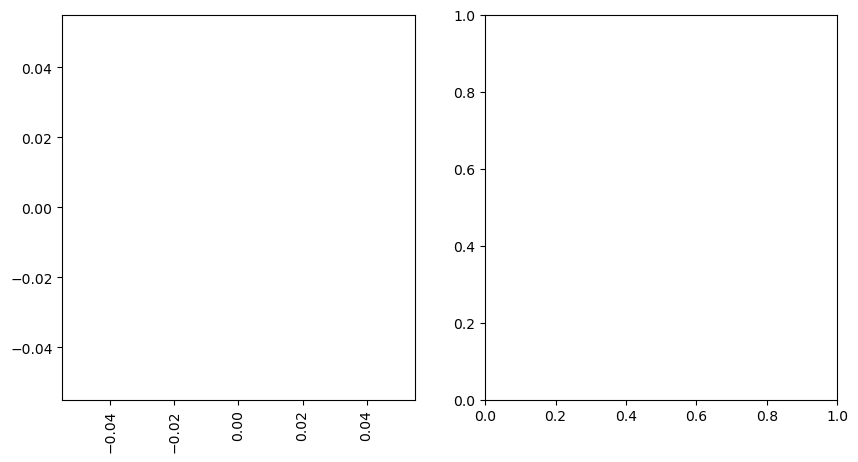

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
train_counts=train.groupby('cell_type')['filename'].count().sort_values(ascending=False)
train_counts.plot(kind='bar', ax=ax[0], color='green')
ax[0].set_title('Counts of Cell Types labels/Train')
ax[0].set_xlabel('Cell Type')
ax[0].set_ylabel('Count of cell labels')
train_counts=train.groupby('cell_type')['filename'].count().sort_values(ascending=False)/train['filename'].nunique()
train_counts.plot(kind='bar', ax=ax[1])
ax[1].set_title('Average of Cell Types labels')
ax[1].set_xlabel('Cell Type')
ax[1].set_ylabel('Count of cell labels')
plt.show()

Most labeled class is 'RBC'. With average of 11 'RBC' per image. Only 1 'WBC' and 'Platelets' in average present on images.
Let's count labels for each cell class for each image

In [9]:
train_df2=train.pivot_table(index='filename', columns='cell_type', values='xmax', aggfunc='count', fill_value=0).reset_index()
train_df2.head()

cell_type,filename,Platelets,RBC,WBC
0,BloodImage_00000.jpg,0,19,1
1,BloodImage_00001.jpg,0,18,1
2,BloodImage_00002.jpg,0,15,1
3,BloodImage_00003.jpg,1,15,1
4,BloodImage_00004.jpg,1,11,1


In [10]:
train_df2.describe()

cell_type,Platelets,RBC,WBC
count,300.000000,300.000000,300.000000
mean,1.013333,11.133333,1.023333
std,1.139070,4.452900,0.250996
min,0.000000,0.000000,0.000000
25%,0.000000,9.000000,1.000000
50%,1.000000,11.000000,1.000000
75%,2.000000,14.000000,1.000000
max,6.000000,27.000000,2.000000


Check outliers for each class of cells

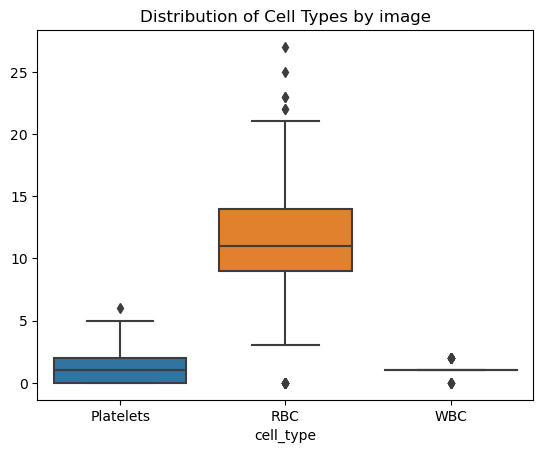

In [11]:
sns.boxplot(data=train_df2)
plt.title('Distribution of Cell Types by image')
plt.show()

In [12]:
print('There are',len(train_df2[train_df2['WBC']==2]),'images with 2 labeled WBC and', len(train_df2[train_df2['WBC']==0]),'with 0 WBC')

There are 13 images with 2 labeled WBC and 6 with 0 WBC


In [13]:
print('More than 3 Platelets are labeled on',len(train_df2[train_df2['Platelets']>3]),'images')

More than 3 Platelets are labeled on 12 images


In [14]:
print('There are',len(train_df2[train_df2['RBC']==0]),'images without RBC labeled')

There are 14 images without RBC labeled


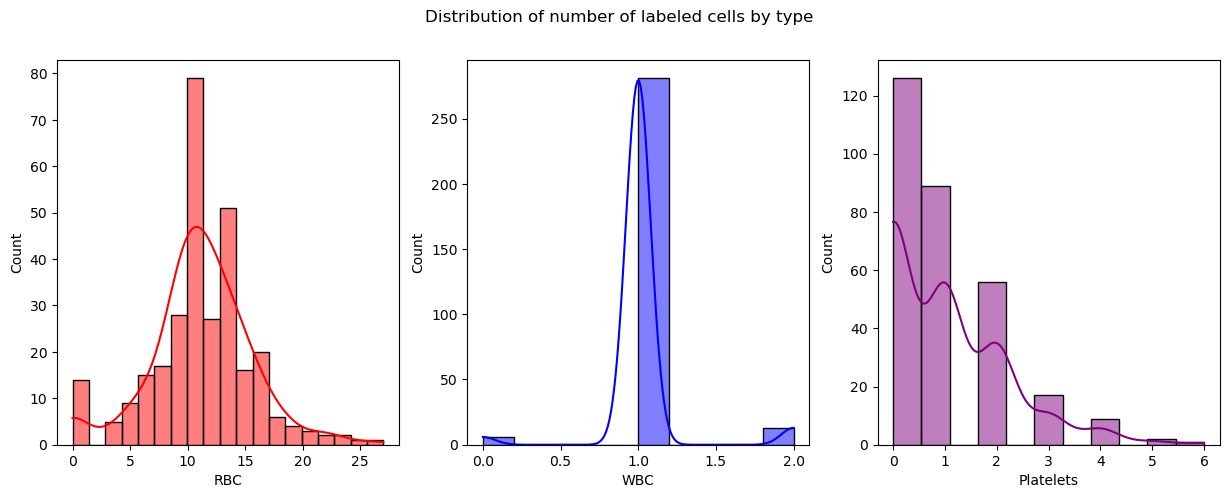

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(train_df2.RBC,  color='red', ax=ax[0], kde=True)
sns.histplot(train_df2.WBC,  color='blue', ax=ax[1], kde=True)
sns.histplot(train_df2.Platelets,  color='purple', ax=ax[2], kde=True)
fig.suptitle('Distribution of number of labeled cells by type')
plt.show()

Let's check height and width of boxes outlining cells on images

In [16]:
train['width']=train['xmax']-train['xmin']
train['height']=train['ymax']-train['ymin']

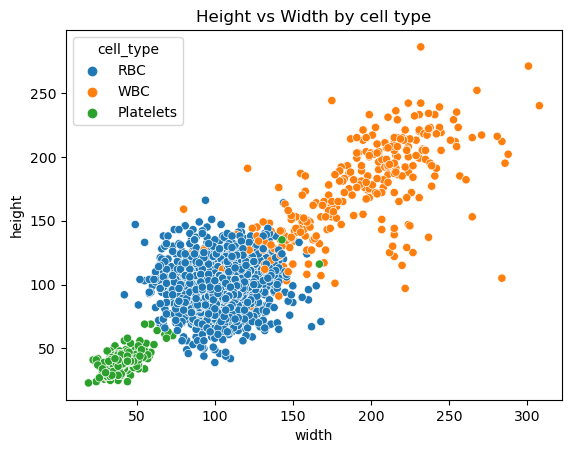

In [17]:
sns.scatterplot(x='width', y='height', data=train, hue='cell_type')
plt.title('Height vs Width by cell type')
plt.show()

From this plot we can see that in most cases we can separate cells classes by their size. Let's check boxplot for width and height by cell types.

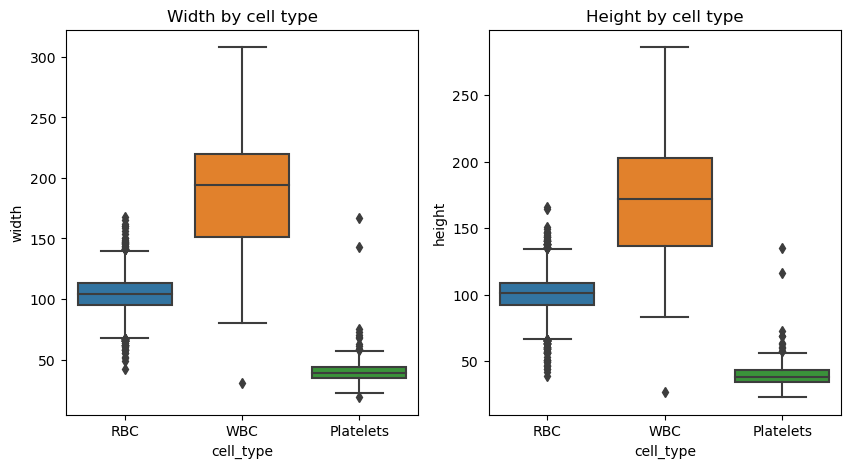

In [18]:
fig, ax=plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(data=train, y='width', x='cell_type', ax=ax[0])
ax[0].set_title('Width by cell type')
sns.boxplot(data=train, y='height', x='cell_type', ax=ax[1])
ax[1].set_title('Height by cell type')
plt.show()

In [19]:
print(train.groupby('cell_type')[['height', 'width']].describe(percentiles=[.05, .95]))

           height                                                            \
            count        mean        std   min     5%    50%     95%    max   
cell_type                                                                     
Platelets   304.0   39.552632  10.301264  23.0   29.0   38.0   52.85  135.0   
RBC        3340.0  100.147006  14.577619  39.0   75.0  101.0  123.00  166.0   
WBC         307.0  169.837134  40.144749  27.0  110.6  172.0  230.40  286.0   

            width                                                             
            count        mean        std   min      5%    50%     95%    max  
cell_type                                                                     
Platelets   304.0   40.957237  12.397759  19.0   29.15   39.0   55.85  167.0  
RBC        3340.0  104.031737  14.800325  42.0   79.00  104.0  128.00  168.0  
WBC         307.0  187.289902  44.220304  31.0  120.00  194.0  254.70  308.0  


Platelets are small cells in 95% cases. Only several images have platelets of height and width more than 56 pixels and height higher 52.85px.
White blood cells are bigger than Red blood cells but their heigh and width can overlap and lead to misclassification.

### Test dataset

In [20]:
test=pd.read_csv('Testing.csv')
test.shape

(907, 6)

In [21]:
print('Missing values in test\n',test.isnull().sum(axis = 0))

Missing values in test
 filename     0
cell_type    0
xmin         0
xmax         0
ymin         0
ymax         0
dtype: int64


In [22]:
print('Number of unique image names', test.filename.nunique())

Number of unique image names 60


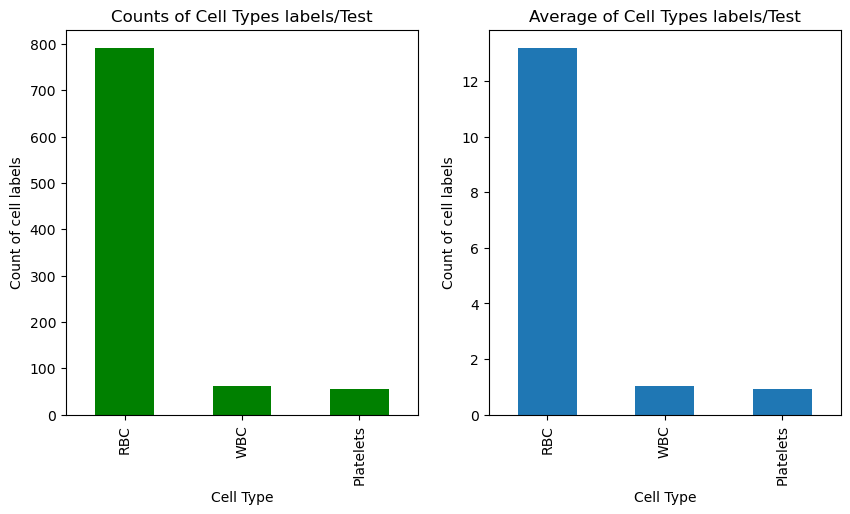

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
test_counts=test.groupby('cell_type')['filename'].count().sort_values(ascending=False)
test_counts.plot(kind='bar', ax=ax[0], color='green')
ax[0].set_title('Counts of Cell Types labels/Test')
ax[0].set_xlabel('Cell Type')
ax[0].set_ylabel('Count of cell labels')
test_counts=test.groupby('cell_type')['filename'].count().sort_values(ascending=False)/test['filename'].nunique()
test_counts.plot(kind='bar', ax=ax[1])
ax[1].set_title('Average of Cell Types labels/Test')
ax[1].set_xlabel('Cell Type')
ax[1].set_ylabel('Count of cell labels')
plt.show()

Distribution of labels looks similar to train dataset. Let's count labes for each class for each image

In [24]:
test_df2=test.pivot_table(index='filename', columns='cell_type', values='xmax', aggfunc='count', fill_value=0).reset_index()
test_df2.head()

cell_type,filename,Platelets,RBC,WBC
0,BloodImage_00339.jpg,2,15,1
1,BloodImage_00340.jpg,0,11,1
2,BloodImage_00343.jpg,2,8,1
3,BloodImage_00344.jpg,1,12,1
4,BloodImage_00345.jpg,0,12,1


In [25]:
test_df2.describe()

cell_type,Platelets,RBC,WBC
count,60.000000,60.000000,60.000000
mean,0.916667,13.183333,1.016667
std,1.225321,2.197778,0.129099
min,0.000000,8.000000,1.000000
25%,0.000000,12.000000,1.000000
50%,0.000000,13.500000,1.000000
75%,2.000000,14.000000,1.000000
max,4.000000,18.000000,2.000000


Check outliers for each class of cells

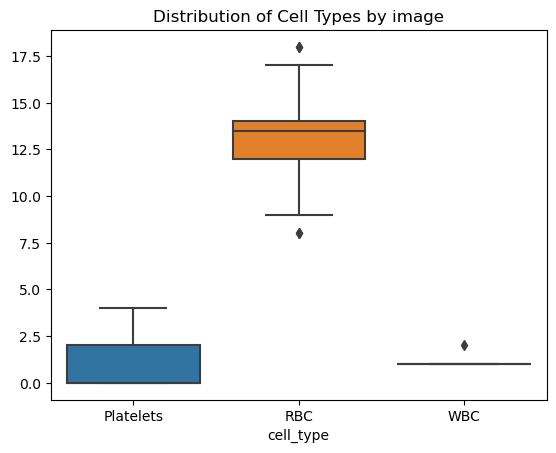

In [26]:
sns.boxplot(data=test_df2)
plt.title('Distribution of Cell Types by image')
plt.show()

In [27]:
print('There are',len(test_df2[test_df2['WBC']==2]),'images with 2 labeled WBC and', len(test_df2[test_df2['WBC']==0]),'with 0 WBC')

There are 1 images with 2 labeled WBC and 0 with 0 WBC


In [28]:
print('More than 3 Platelets are labeled on',len(test_df2[test_df2['Platelets']>3]),'images')

More than 3 Platelets are labeled on 3 images


In [29]:
print('There are',len(test_df2[test_df2['RBC']==0]),'images without RBC labeled')

There are 0 images without RBC labeled


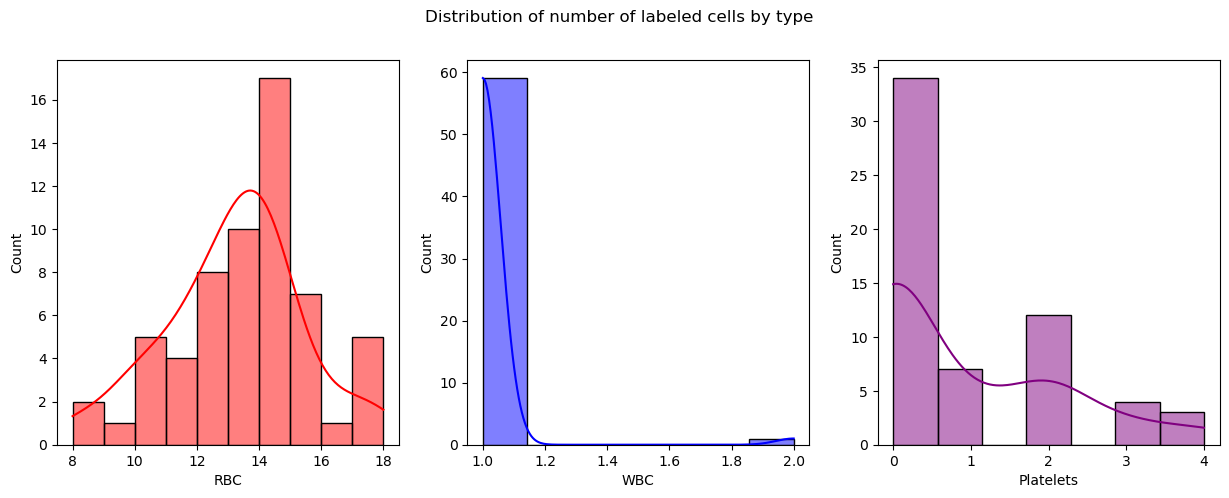

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(test_df2.RBC,  color='red', ax=ax[0], kde=True)
sns.histplot(test_df2.WBC,  color='blue', ax=ax[1], kde=True)
sns.histplot(test_df2.Platelets,  color='purple', ax=ax[2], kde=True)
fig.suptitle('Distribution of number of labeled cells by type')
plt.show()

In [31]:
test['width']=test['xmax']-test['xmin']
test['height']=test['ymax']-test['ymin']

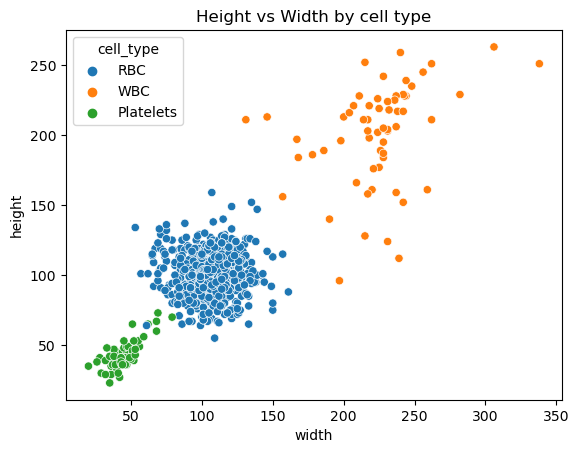

In [32]:
sns.scatterplot(x='width', y='height', data=test, hue='cell_type')
plt.title('Height vs Width by cell type')
plt.show()

Test dataset has more distinguished separation between classes by their size. Let's check boxplot for width and height by cell types.

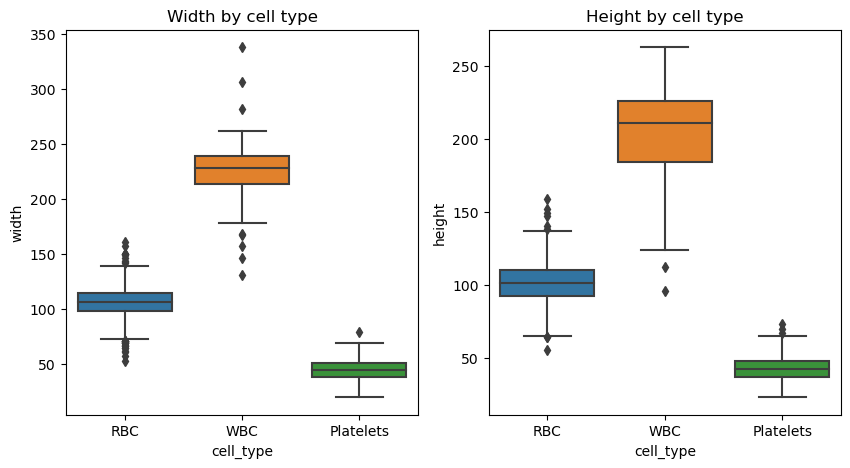

In [33]:
fig, ax=plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(data=test, y='width', x='cell_type', ax=ax[0])
ax[0].set_title('Width by cell type')
sns.boxplot(data=test, y='height', x='cell_type', ax=ax[1])
ax[1].set_title('Height by cell type')
plt.show()

In [34]:
print(test.groupby('cell_type')[['height', 'width']].describe(percentiles=[.05, .95]))

          height                                                           \
           count        mean        std   min     5%    50%    95%    max   
cell_type                                                                   
Platelets   55.0   43.763636  10.699539  23.0   29.0   42.0   65.6   73.0   
RBC        791.0  101.310999  14.124111  55.0   77.5  101.0  123.0  159.0   
WBC         61.0  201.229508  36.308123  96.0  128.0  211.0  251.0  263.0   

           width                                                            
           count        mean        std    min     5%    50%    95%    max  
cell_type                                                                   
Platelets   55.0   45.345455  11.102583   20.0   28.7   45.0   68.0   79.0  
RBC        791.0  106.218710  14.787318   53.0   81.0  106.0  130.0  161.0  
WBC         61.0  224.180328  33.290393  131.0  167.0  228.0  262.0  338.0  


By average cells in testing dataset are little big bigger by width and height than same cells in training dataset. 

## Plot images and boxes

In [35]:
def plot_img(df, imgdir, image_name):
    
    fig, ax = plt.subplots(1, 2, figsize = (14, 14))
    ax = ax.flatten()
    
    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(imgdir, image_name)
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image
    
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['cell_type']
        
        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0), 3)
        font = cv2.FONT_ITALIC
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, (255,0,0), 2)
    
    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

In [36]:
training_images = glob(f'{cwd}/Training/Images')
testing_images = glob(f'{cwd}/Testing/Images')

### Plot random image from Train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


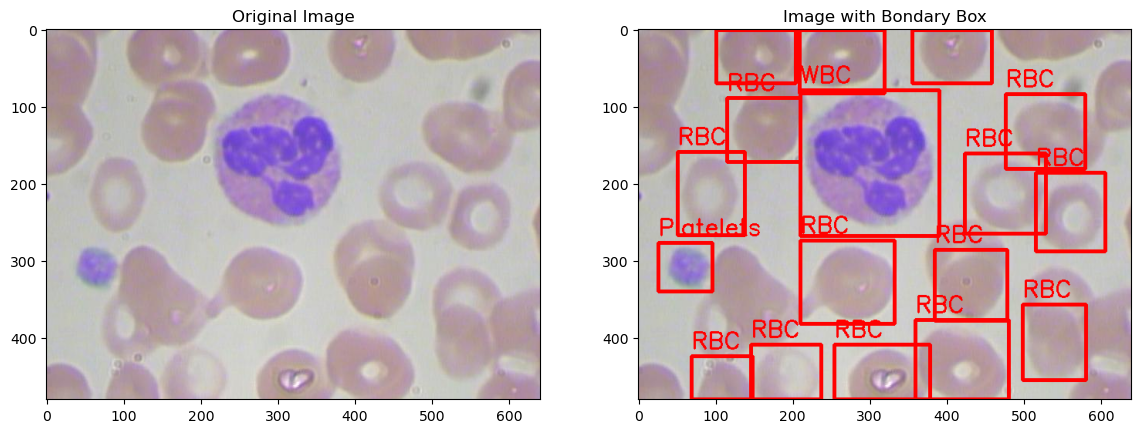

In [37]:
plot_img(train, training_images[0], train['filename'].sample().iloc[0])

### Plot random image without RBC labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


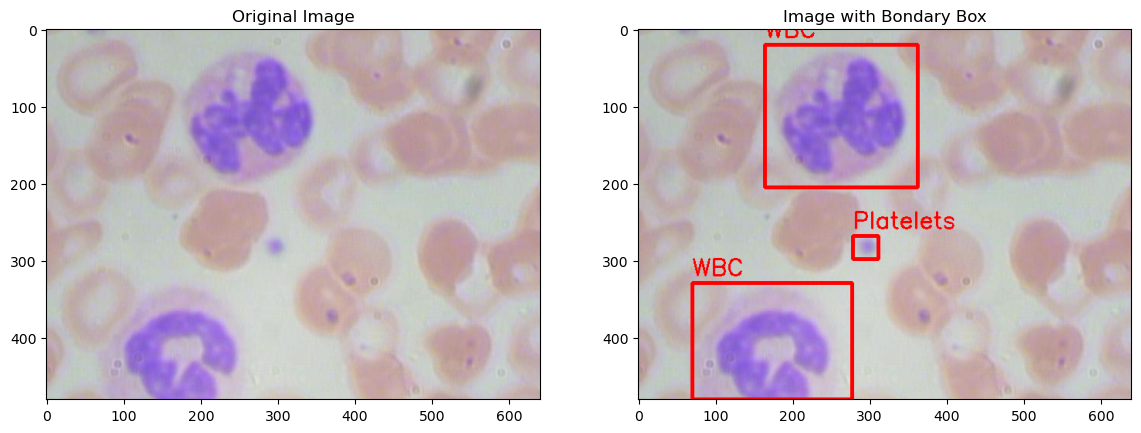

In [38]:
empty_rbc=train_df2[train_df2['RBC']==0]
plot_img(train, training_images[0], empty_rbc['filename'].sample().iloc[0])

### Plot images of max size for RBC, WBC and Platelets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Biggest RBC cell is in BloodImage_00139.jpg


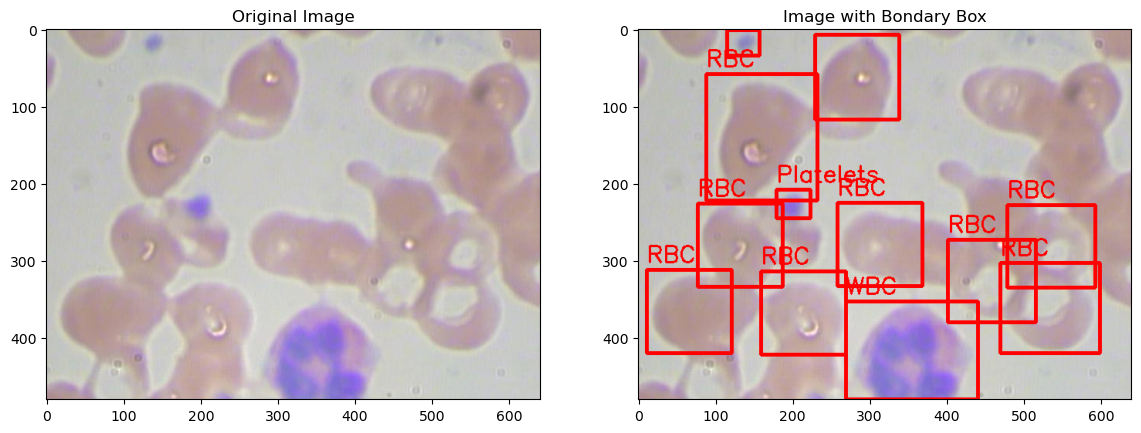

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Biggest WBC cell is in BloodImage_00284.jpg


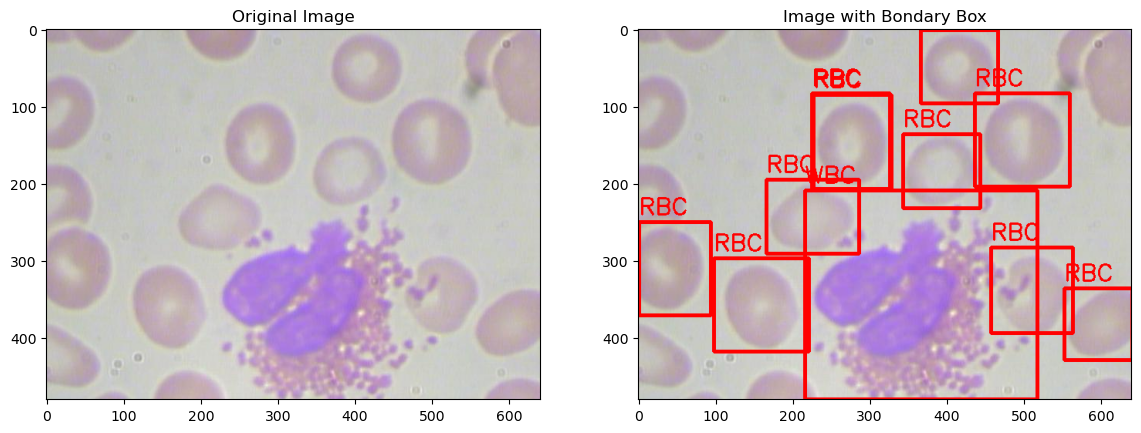

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Biggest Platelets cell is in BloodImage_00133.jpg


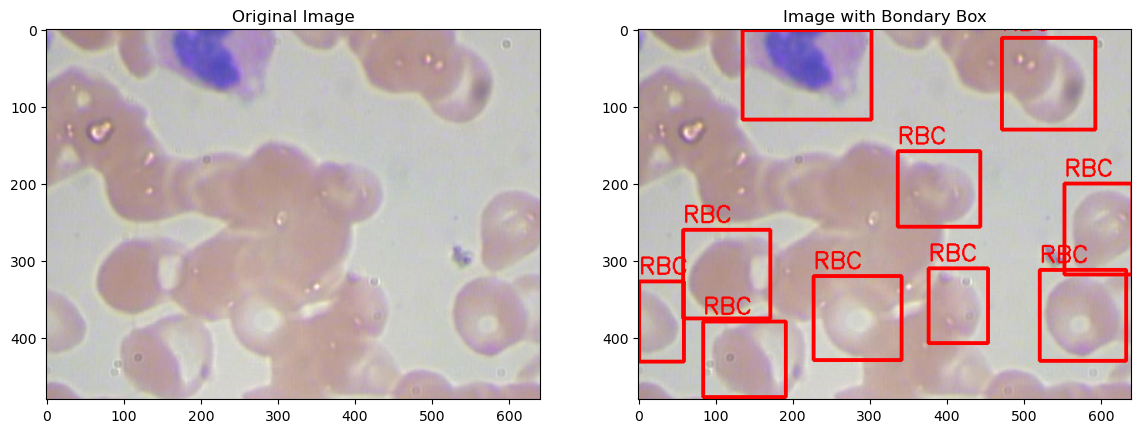

In [39]:
train['area']=train['height']*train['width']
for c in list(train['cell_type'].unique()):
    c_df = train[train['cell_type'] == c]
    max_area = c_df['area'].max()
    filename = c_df[c_df['area'] == max_area]['filename'].iloc[0]
    print('Biggest',c,'cell is in',filename)
    plot_img(train, training_images[0], filename)
    

## Check duplicates in images

In [40]:
tr_images = []

for filename in os.listdir(training_images[0]):
    img = cv2.imread(os.path.join(training_images[0], filename))
    if img is not None:
        tr_images.append(img)
for filename in os.listdir(testing_images[0]):
    img = cv2.imread(os.path.join(testing_images[0], filename))
    if img is not None:
        tr_images.append(img)
print('Number of images loaded:', len(tr_images))

Number of images loaded: 360


In [41]:
import hashlib

hashes = []

for img in tr_images:
    hashi = hashlib.md5(img).hexdigest()
    hashes.append(hashi)

duplicates = []

for i in range(len(hashes)):
    for j in range(i+1, len(hashes)):
        if hashes[i] == hashes[j]:
            duplicates.append((i, j))

print('Number of duplicates:', len(duplicates))

Number of duplicates: 0
